In [1]:
# Importation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

In [3]:
# Définition de la courbe paramétrique en forme de coeur (Gamma)
def gamma_heart(t):
    """
    Définir les coordonnées x(t) et y(t) de la courbe Gamma en forme de coeur.
    """
    x = np.cos(2 * np.pi * t)
    y = 2 * np.sin(2 * np.pi * t) + np.sqrt(np.abs(np.cos(2 * np.pi * t)))
    return x + 1j * y  # Retourne une valeur complexe pour faciliter la DFT

In [4]:
# Définition de la Transformée de Fourier Discrète (DFT)
def dft_from_scratch(x, N=None):
    """
    Calculer la Transformée de Fourier Discrète (DFT) d'un signal x.
    Si N est spécifié, utiliser N coefficients harmoniques.
    """
    if N is None:
        N = len(x)
    n = np.arange(len(x))
    k = np.arange(N).reshape((N, 1))
    # Calcul de la matrice de Fourier avec l'exponentielle complexe
    M = np.exp(-2j * np.pi * k * n / len(x))
    return np.dot(M, x)

In [5]:
# Définition de l'inverse de la DFT (iDFT)
def idft_from_scratch(X, N=None):
    """
    Calculer l'inverse de la Transformée de Fourier Discrète (IDFT) d'un signal X.
    Si N est spécifié, utiliser N coefficients harmoniques pour la reconstruction.
    """
    if N is None:
        N = len(X)
    k = np.arange(len(X))
    n = np.arange(N).reshape((N, 1))
    # Calcul de la matrice de Fourier inverse
    M = np.exp(2j * np.pi * k * n / len(X))
    return np.dot(M, X) / len(X)

In [6]:
# Calcul des invariants de Crimmins pour un ensemble donné de coefficients
def crimmins_invariants(C, k0, k1):
    """
    Calculer les invariants de Crimmins I_k pour des indices k0 et k1 donnés.
    """
    invariants = []
    for k in range(len(C)):
        if k == k0:
            I_k = np.abs(C[k0])
        elif k == k1:
            I_k = np.abs(C[k1])
        else:
            I_k = (C[k])**(k0 - k1) * C[k0])**(k - k1) * (C[k1])**(k - k0)
        invariants.append(I_k)
    return np.array(invariants)

In [7]:
# Fonction pour appliquer une transformation (rotation, échelle, décalage) à la courbe Gamma
def transform_gamma(gamma, rotation=0, scale=1, delay=0):
    """
    Appliquer une rotation, une mise à l'échelle et un décalage temporel à la courbe Gamma.
    """
    gamma_transformed = scale * gamma * np.exp(1j * rotation)
    delay_samples = int(delay * len(gamma))  # Décalage en termes d'échantillons
    return np.roll(gamma_transformed, delay_samples)

In [13]:
# Fonction pour reconstruire Gamma à partir d'un nombre limité d'harmoniques de Fourier
def reconstruct_from_harmonics(C, num_harmonics):
    """
    Reconstruire la courbe en utilisant un nombre limité d'harmoniques centrés autour de 0.
    """
    C_reduced = np.zeros_like(C)
    center = len(C) // 2
    C_reduced[center - num_harmonics:center + num_harmonics + 1] = C[center - num_harmonics:center + num_harmonics + 1]
    return idft_from_scratch(C_reduced)

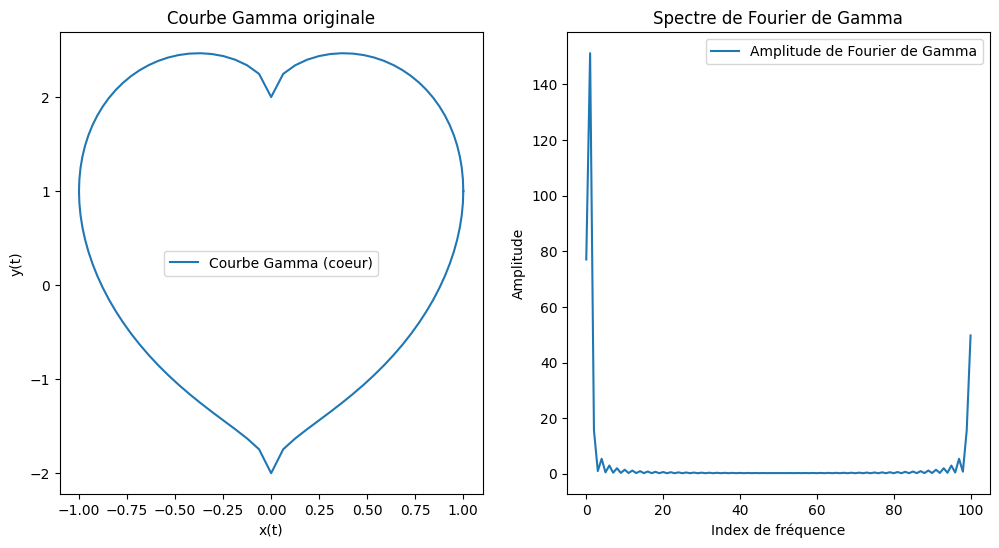

In [20]:
# Étape 1 : Générer Gamma et calculer sa DFT
t = np.arange(0, 1.01, 0.01)
gamma = gamma_heart(t)
C_gamma = dft_from_scratch(gamma)

# Étape 2 : Calculer les invariants de Crimmins pour Gamma original
k0, k1 = 10, 21  # Indices de référence pour Crimmins
invariants_gamma = crimmins_invariants(C_gamma, k0, k1)

# Affichage de la courbe originale et de son spectre de Fourier
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(gamma.real, gamma.imag, label="Courbe Gamma (coeur)")
plt.title("Courbe Gamma originale")
plt.xlabel("x(t)")
plt.ylabel("y(t)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.abs(C_gamma), label="Amplitude de Fourier de Gamma")
plt.title("Spectre de Fourier de Gamma")
plt.xlabel("Index de fréquence")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

Invariants originaux: [1.04439112e-18 2.14670965e-22 4.91764359e-12 2.59289262e+01
 6.69109012e-08]
Invariants après rotation: [1.04439112e-18 2.14670965e-22 4.91764359e-12 2.59289262e+01
 6.69109012e-08]
Invariants après mise à l'échelle: [3.83652110e-46 1.59688175e-48 7.40766828e-37 7.90922693e-23
 4.13305715e-30]
Invariants après décalage: [1.04439112e-18 2.14670965e-22 4.91764359e-12 2.59289262e+01
 6.69109012e-08]


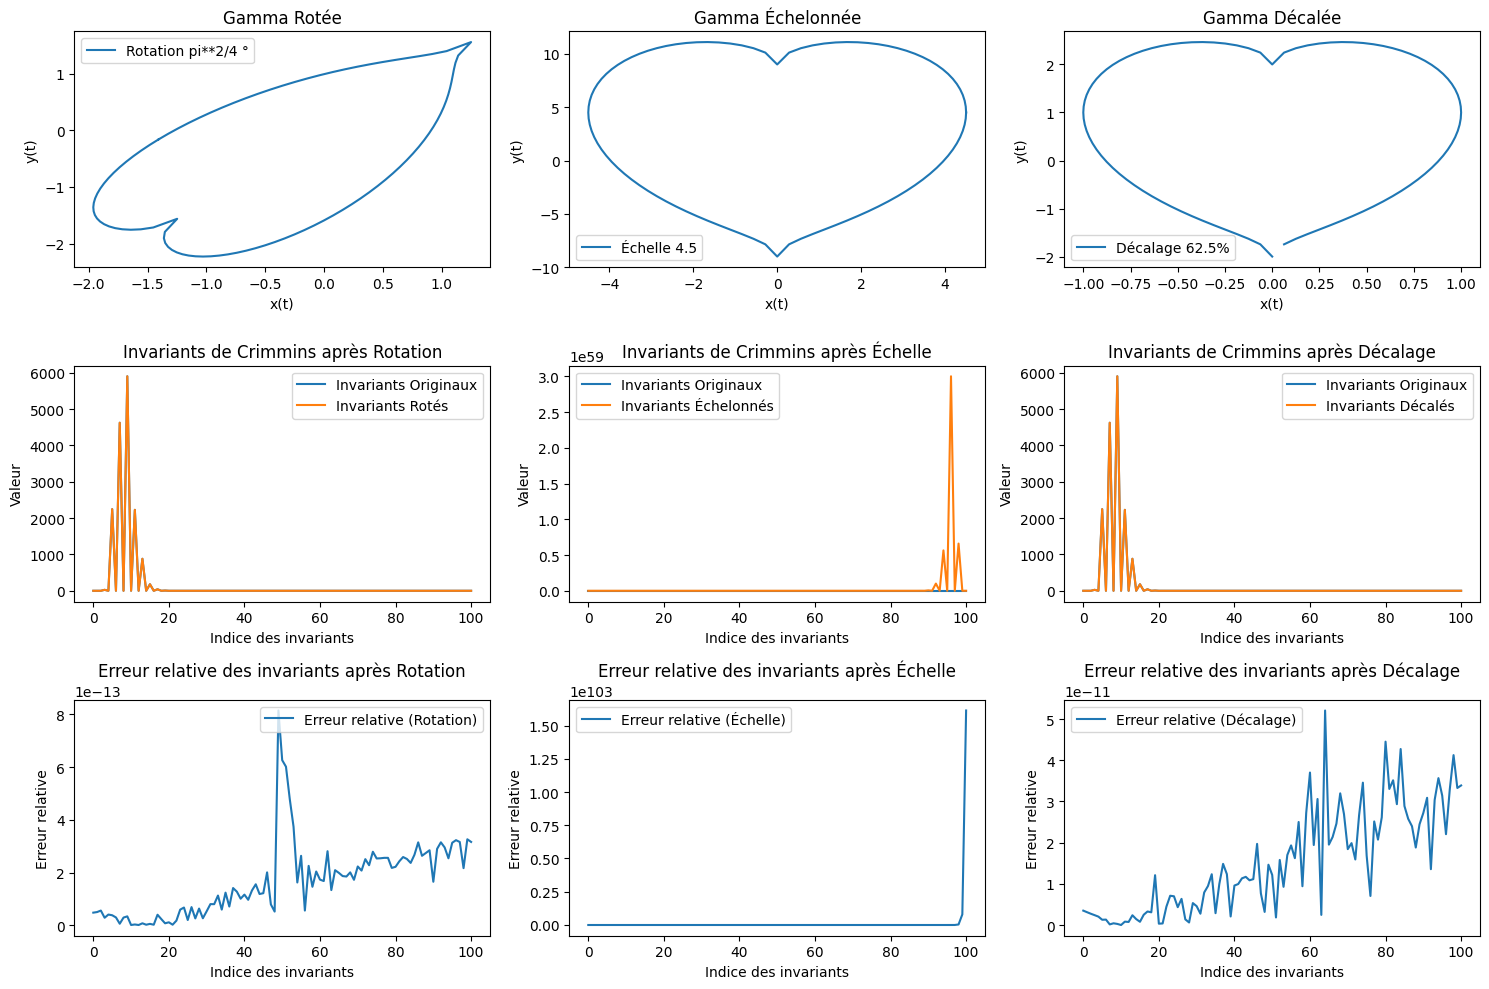

In [23]:
# Étape 3 : Tester l'invariance sous transformations
gamma_rotated = transform_gamma(gamma, rotation=np.pi/4*np.pi)  # Rotation de pi**2/4 degrés
gamma_scaled = transform_gamma(gamma, scale=4.5)          # Échelle de 4.5
gamma_delayed = transform_gamma(gamma, delay=6.25)         # Décalage de 6.25%

# Calcul de la DFT pour les versions transformées
C_rotated = dft_from_scratch(gamma_rotated)
C_scaled = dft_from_scratch(gamma_scaled)
C_delayed = dft_from_scratch(gamma_delayed)

# Calcul des invariants pour chaque transformation
invariants_rotated = crimmins_invariants(C_rotated, k0, k1)
invariants_scaled = crimmins_invariants(C_scaled, k0, k1)
invariants_delayed = crimmins_invariants(C_delayed, k0, k1)

# Comparaison des invariants
print("Invariants originaux:", invariants_gamma[:5])
print("Invariants après rotation:", invariants_rotated[:5])
print("Invariants après mise à l'échelle:", invariants_scaled[:5])
print("Invariants après décalage:", invariants_delayed[:5])

# Calcul des erreurs relatives
relative_error_rotation = np.abs((invariants_rotated - invariants_gamma) / invariants_gamma)
relative_error_scale = np.abs((invariants_scaled - invariants_gamma) / invariants_gamma)
relative_error_delay = np.abs((invariants_delayed - invariants_gamma) / invariants_gamma)

# Étape 3 bis : Visualisation des transformations et des erreurs relatives
plt.figure(figsize=(15, 10))

# Sous-graphiques des courbes transformées
plt.subplot(3, 3, 1)
plt.plot(gamma_rotated.real, gamma_rotated.imag, label="Rotation pi**2/4 °")
plt.xlabel("x(t)")
plt.ylabel("y(t)")
plt.legend()
plt.title("Gamma Rotée")

plt.subplot(3, 3, 2)
plt.plot(gamma_scaled.real, gamma_scaled.imag, label="Échelle 4.5")
plt.xlabel("x(t)")
plt.ylabel("y(t)")
plt.legend()
plt.title("Gamma Échelonnée")

plt.subplot(3, 3, 3)
plt.plot(gamma_delayed.real, gamma_delayed.imag, label="Décalage 62.5%")
plt.xlabel("x(t)")
plt.ylabel("y(t)")
plt.legend()
plt.title("Gamma Décalée")

# Sous-graphiques des invariants de Crimmins
plt.subplot(3, 3, 4)
plt.plot(invariants_gamma, label="Invariants Originaux")
plt.plot(invariants_rotated, label="Invariants Rotés")
plt.xlabel("Indice des invariants")
plt.ylabel("Valeur")
plt.legend()
plt.title("Invariants de Crimmins après Rotation")

plt.subplot(3, 3, 5)
plt.plot(invariants_gamma, label="Invariants Originaux")
plt.plot(invariants_scaled, label="Invariants Échelonnés")
plt.xlabel("Indice des invariants")
plt.ylabel("Valeur")
plt.legend()
plt.title("Invariants de Crimmins après Échelle")

plt.subplot(3, 3, 6)
plt.plot(invariants_gamma, label="Invariants Originaux")
plt.plot(invariants_delayed, label="Invariants Décalés")
plt.xlabel("Indice des invariants")
plt.ylabel("Valeur")
plt.legend()
plt.title("Invariants de Crimmins après Décalage")

# Sous-graphiques des erreurs relatives
plt.subplot(3, 3, 7)
plt.plot(relative_error_rotation, label="Erreur relative (Rotation)")
plt.xlabel("Indice des invariants")
plt.ylabel("Erreur relative")
plt.legend()
plt.title("Erreur relative des invariants après Rotation")

plt.subplot(3, 3, 8)
plt.plot(relative_error_scale, label="Erreur relative (Échelle)")
plt.xlabel("Indice des invariants")
plt.ylabel("Erreur relative")
plt.legend()
plt.title("Erreur relative des invariants après Échelle")

plt.subplot(3, 3, 9)
plt.plot(relative_error_delay, label="Erreur relative (Décalage)")
plt.xlabel("Indice des invariants")
plt.ylabel("Erreur relative")
plt.legend()
plt.title("Erreur relative des invariants après Décalage")

plt.tight_layout()
plt.show()

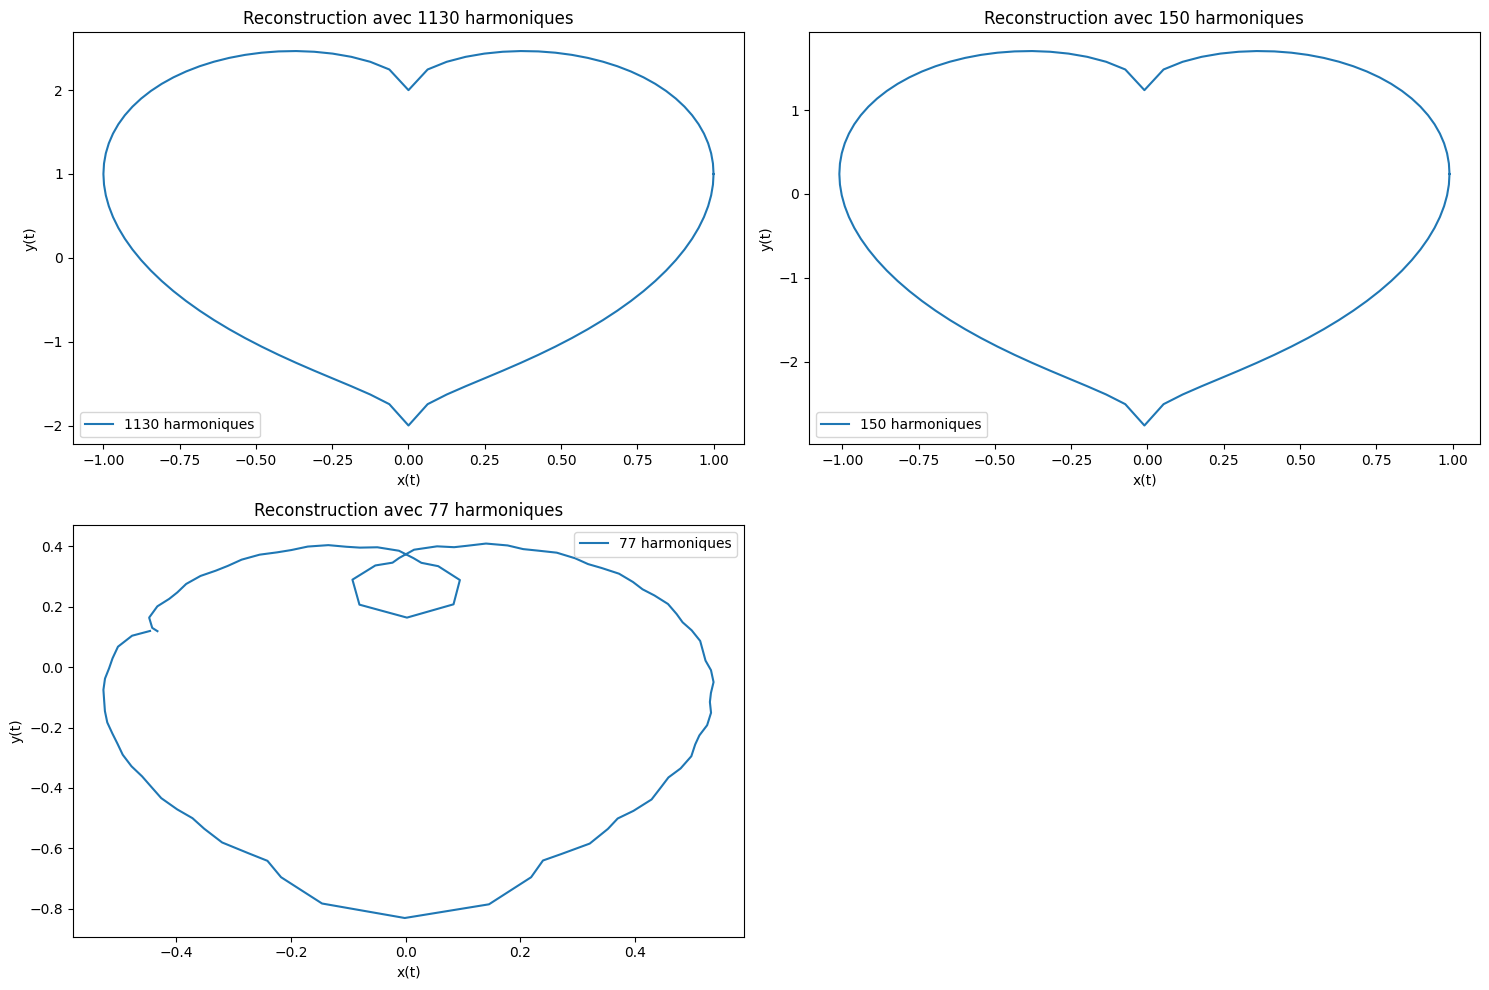

In [19]:
# Étape 4 : Reconstruction à partir d'un nombre limité d'harmoniques
harmonics_intervals = [1130, 150, 77]
plt.figure(figsize=(15, 10))
for i, num_harmonics in enumerate(harmonics_intervals):
    gamma_reconstructed = reconstruct_from_harmonics(C_gamma, num_harmonics)
    plt.subplot(2, 2, i+1)
    plt.plot(gamma_reconstructed.real, gamma_reconstructed.imag, label=f"{num_harmonics} harmoniques")
    plt.title(f"Reconstruction avec {num_harmonics} harmoniques")
    plt.xlabel("x(t)")
    plt.ylabel("y(t)")
    plt.legend()

plt.tight_layout()
plt.show()


# Étape 4 bis : Analyser la complétude
# Observer comment la reconstruction change avec la réduction des harmoniques,
# et si la forme du coeur est bien préservée.